In [95]:
!pip install -q transformers
!pip install -q umap
!pip install -q japanize-matplotlib
!pip install -q neologdn
!pip install -q emoji
!pip install -q janome


     |████████████████████████████████| 19.7 MB 1.2 MB/s 


In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [138]:
import os 
import time 
import pickle 
import gc 
import random 
import string 
import warnings
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import joblib 

import neologdn
import re 
import emoji
from janome.tokenizer import Tokenizer

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score 
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
import umap

import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import  AutoConfig, AutoTokenizer, logging, AutoModel
from transformers import AdamW

In [22]:
train = pd.read_csv("rakuten_recipe (1).csv", usecols=["categoryName", "recipeDescription", "recipeIndication", "recipeTitle"])
material = pd.read_csv("rakuten_recipe_material.csv")

assert train.shape[0] == material.shape[0]
train.head()

,categoryName,recipeDescription,recipeIndication,recipeTitle
0,人気メニュー,食べだすと、とまりません･:*+٩(๑❛ᴗ❛๑)۶.:+\n里芋に片栗粉をまぶして揚げたもの...,約15分,食べだすと、とまらない☆揚げ里芋の甘辛！
1,人気メニュー,お弁当のおかずにと思って作ったら、主人が、お弁当箱の半分のスペースは、これでいいよと言うぐら...,約10分,主人が、いくらでも食べれると絶賛のナス・ピーマン
2,人気メニュー,里芋のトロンとした食感がたまらない♪\n味をしっかり染みこませるために、ほんのひと手間をd(...,指定なし,ほっこり～☆里芋のひき肉あんかけ
3,人気メニュー,好評の為レシピを分かりやすくしました。\n分量を多少変更しました。（２０１３年３月）\n以前...,約1時間,元店長がこっそり教えるびっくり◯ンキーのハンバーグ
4,定番の肉料理,鶏胸肉なのにウイング風♬骨が無いので食べ易くお弁当にもピッタリ♡油で揚げないのでヘルシーです♪,約10分,鶏胸肉で簡単♪手羽風揚げない甘辛照焼チキンお弁当に


In [24]:
print(f"before shape: {train.shape[0]}")
df = pd.merge(train, material, how="inner", left_index=True, right_index=True)
df = df.drop_duplicates(subset=["recipeTitle"]).reset_index(drop=True)
print(f"after merged shape: {df.shape[0]}")

before shape: 8640
after merged shape: 4603


In [26]:
df.head()

,categoryName,recipeDescription,recipeIndication,recipeTitle,里芋,玉ねぎ,大根,人参,レタス,白菜,ミニトマト,ねぎ,にんにく,キャベツ,じゃがいも,グリーンピース,ほうれん草,しょうが,パセリ,しめじ,ごぼう,もやし,エノキ,春菊,コーン,水菜,柚子,きゅうり,トマト,ブロッコリー,ピーマン,ちんげん菜,ナス,菊芋,かぼちゃ,山芋,アスパラ,パプリカ,バジル,マッシュルーム,...,ケチャップ,豆板醤,ナンプラー,マーガリン,デミグラスソース,クミン,ターメリック,ガラムマサラ,ポン酢,蕎麦,うどん,中華麺,パスタ,ニョッキ,そうめん,油揚げ,カニカマ,牛乳,明太子,冷凍餃子,こんにゃく,豆腐,葛きり,蒲鉾,餅,梅干し,わかめ,昆布,ヨーグルト,春雨,たらこ,チーズ,ミートソース,しらたき,納豆,キムチ,海苔,おから,パン,レモン
0,人気メニュー,食べだすと、とまりません･:*+٩(๑❛ᴗ❛๑)۶.:+\n里芋に片栗粉をまぶして揚げたもの...,約15分,食べだすと、とまらない☆揚げ里芋の甘辛！,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,人気メニュー,お弁当のおかずにと思って作ったら、主人が、お弁当箱の半分のスペースは、これでいいよと言うぐら...,約10分,主人が、いくらでも食べれると絶賛のナス・ピーマン,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,人気メニュー,里芋のトロンとした食感がたまらない♪\n味をしっかり染みこませるために、ほんのひと手間をd(...,指定なし,ほっこり～☆里芋のひき肉あんかけ,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,人気メニュー,好評の為レシピを分かりやすくしました。\n分量を多少変更しました。（２０１３年３月）\n以前...,約1時間,元店長がこっそり教えるびっくり◯ンキーのハンバーグ,0,1,1,1,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,定番の肉料理,鶏胸肉なのにウイング風♬骨が無いので食べ易くお弁当にもピッタリ♡油で揚げないのでヘルシーです♪,約10分,鶏胸肉で簡単♪手羽風揚げない甘辛照焼チキンお弁当に,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
df.categoryName.value_counts(normalize=True)

その他のお肉              0.001521
その他の食材              0.001303
ねぎま鍋                0.001303
カレー鍋                0.001303
かぶら蒸し               0.001303
                      ...   
小麦を使わない（小麦アレルギー）    0.000217
さばの味噌煮              0.000217
ル・クルーゼ              0.000217
蒸しパン                0.000217
タイ料理                0.000217
Name: categoryName, Length: 1590, dtype: float64

# クラスタリング分析
教師なし学習で分類する  
訓練データとして料理に使用される材料を用いた。

In [53]:
tsne = TSNE(n_components=3, random_state=42).fit_transform(df[material.columns.tolist()])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


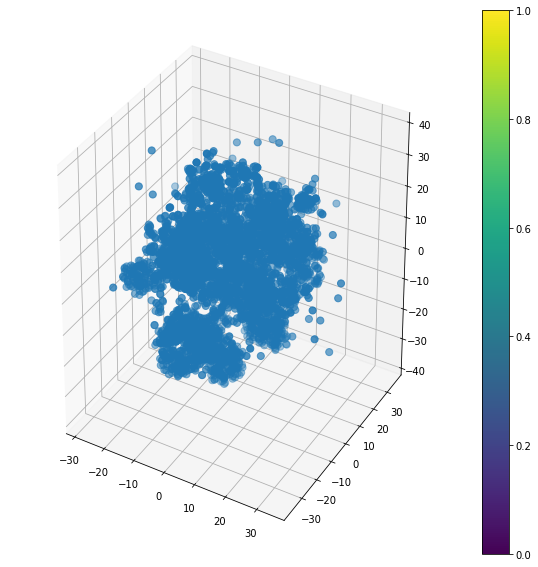

In [54]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111 , projection='3d')
sc = ax.scatter(tsne[:, 0], 
                tsne[:, 1],
                zs=tsne[:, 2],
                zdir='z',
                s=50,
                vmin=0,
                vmax=1,
                # c=[:, 3],
                cmap=plt.cm.jet) 
plt.colorbar(sc)
plt.show()

In [55]:
km = KMeans(n_clusters=40, random_state=42)
y_km = km.fit_predict(tsne)

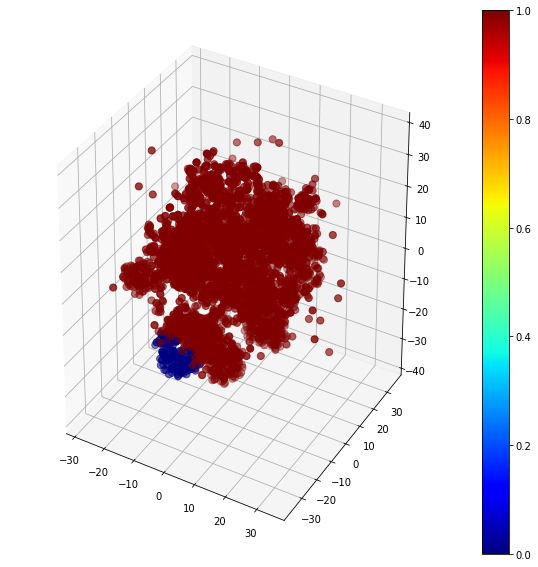

In [56]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111 , projection='3d')
sc = ax.scatter(tsne[:, 0], 
                tsne[:, 1],
                zs=tsne[:, 2],
                zdir='z',
                s=50,
                vmin=0,
                vmax=1,
                c=y_km,
                cmap=plt.cm.jet) 
plt.colorbar(sc)
plt.show()

In [57]:
y_km

array([15, 28, 29, ..., 29,  1, 20], dtype=int32)

In [58]:
df["cluster"] = y_km 

for cluster in df.cluster.unique():
    print(f"Cluster == {cluster}")
    display(df.loc[df.cluster == cluster, "recipeTitle"].sample(5))
    print(f"Length {len(df[df.cluster == cluster])}")
    print("="*20)

Cluster == 15


4122           簡単！美味しい！大根の醤油漬け
3745          簡単‼ ねじりこんにゃくの甘辛煮
3869    簡単おつまみ！ほうれん草とえのきの中華風和え
565        ごま香る!!我が家の病みつきゴマドレ♪
3075         こっくり♪ほうれん草の練り胡麻和え
Name: recipeTitle, dtype: object

Length 117
Cluster == 28


4156      圧力鍋de☆きのこの炊き込みご飯
2198             普通のひじきの煮物
747     ダシがうまい！！おでんのだし（つゆ）
2422       めんつゆで簡単♪手作り蕎麦つゆ
3716      椎茸の甘味が美味しい切り干し大根
Name: recipeTitle, dtype: object

Length 131
Cluster == 29


1805           全部食べられるカサゴとメバルの唐揚げ
3829    大量消費！止まらない！激ウマさつまいもスティック♪
1792                    わかさぎのから揚げ
4017     1番好きな食べ方♪シンプルにフライパンで焼きなす
1567       10分で作る♪混ぜるだけの佃煮（佃煮のタレ）
Name: recipeTitle, dtype: object

Length 120
Cluster == 21


1799              簡単でサクサク！キスフライ♪
3271                 ペリメニ、ロシア風餃子
3679    ひき肉なしで、ほんとうに美味しい簡単コロッケ！！
3810     衣サクサク！鶏むね肉で！驚きの柔らかチキンカツ
3823                    基本のあじフライ
Name: recipeTitle, dtype: object

Length 78
Cluster == 38


1116          コロコロ厚揚げのみぞれ生姜焼き♪
2024            シンプル簡単　中華菜の炒め物
192             簡単おつまみ＊屋台風イカ焼き
1165          彼のすごーく気に入った薬膳スープ
1221    ピーマン、豚肉、しめじのチンジャオロース風♪
Name: recipeTitle, dtype: object

Length 98
Cluster == 8


2902            材料２つ!! 簡単生チョコ♡
3783              金柑（キンカン）の甘露煮
3404    簡単な 抹茶 クリーム フラペチーノの作り方
3087               イチゴソース♡トースト
3048         お祭り気分♪アルプス乙女のリンゴ飴
Name: recipeTitle, dtype: object

Length 178
Cluster == 20


3797         アスパラ入り！ガーリックシュリンプ！
1409            シイラのムニエル　バター醤油味
563     文句なしに美味しいごちそうサラダ☆きのこサラダ
1918       食べたら止まらない！きぬさやのバター炒め
3191               HBでソフトプレッツェル
Name: recipeTitle, dtype: object

Length 112
Cluster == 35


1840                 サトイモとヒイカの煮物
219     めちゃめちゃゴハンがすすむ！茄子と豚肉の味噌炒め
2142        冷めても美味しい　基本のがんもどきの煮物
227         子供のおやつに☆フライパンで作る大学イモ
240             お箸が止まらない！ゴボウの甘辛煮
Name: recipeTitle, dtype: object

Length 125
Cluster == 18


281             居酒屋☆薄揚げの味噌マヨチーズ焼き
111     店より美味い！ねっとり絶品焼き芋★オーブンレンジで
2508            チンゲンサイと薄切りかぶのお味噌汁
1866                美味しいしじみ汁の☆作り方
2519                さつまいもとわかめの味噌汁
Name: recipeTitle, dtype: object

Length 116
Cluster == 39


1314         サムギョプサル☆おうちで本格韓国料理
1144    レンジで簡単☆お弁当に！塩昆布入り無限ピーマン
579          簡単プロ直伝！叙々苑風チョレギサラダ
4576     簡単！！鶏もも肉の、たっぷりネギごま油かけ❤
1953                       せりご飯
Name: recipeTitle, dtype: object

Length 128
Cluster == 17


1317                       カルビクッパ
2424              辛ラーメンで 汁なし辛旨まぜ麺
2542    ♡10分で簡単即席スープ♪ふわふわ卵わかめスープ♡
2545                簡単！鶏ガラ粉末で卵スープ
1428              小松菜と豚肉の豆腐チャンプルー
Name: recipeTitle, dtype: object

Length 75
Cluster == 23


1429       スパムの油分で！ヘルシーゴーヤチャンプルー
620              魔法の水でしっとり☆出汁巻き卵
57             お酢で疲労回復☆手羽元のさっぱり煮
259                     長芋ふわとろ焼き
1427    夏だ！絹ごし豆腐でふんわりゴーヤーチャンプルー♪
Name: recipeTitle, dtype: object

Length 106
Cluster == 27


379       【市販アレンジ】濃厚！たらこクリームパスタ
4179    超簡単10分以内！もっちりベーコントマトパスタ
2559             肉だんごと白菜と春雨のスープ
394              簡単♪我が家の“納豆パスタ”
372          じゃがいもとベーコンのジェノベーゼ！
Name: recipeTitle, dtype: object

Length 97
Cluster == 37


3949          大阪人が作る　ねぎ焼き
2328                ナシゴレン
1437    海ぶどうの食感が楽しめるちらし寿司
2127         簡単美味しいパクチー炒め
1702    残った焼鮭で簡単！！鮭チャーハン☆
Name: recipeTitle, dtype: object

Length 100
Cluster == 4


3257     お家にある材料で☆本格ビーフストロガノフ
4072               レンズ豆の大根サラダ
504         大根とベーコンのクリームシチュー♡
2720      帝国ホテルのシェフ宅のオニオンソース！
311     炊飯器とシーフードミックスで簡単　パエリア
Name: recipeTitle, dtype: object

Length 188
Cluster == 16


62      ファスティング／梅流し(すっきり大根)◆回腹食①
534        洗っただけで食べられる『サラダほうれん草』
1162          まるで帆立！エリンギのバター醤油焼き
1980                モロヘイヤとツナの和え物
2076                 手羽元と大根の白だし煮
Name: recipeTitle, dtype: object

Length 89
Cluster == 12


1297      Korean☆韓国人に教えてもらった本格キムチ
1225                色々野菜で☆中華風あんかけ
206                ポカポカ温まる！牡蠣の味噌鍋
742              【定番】すき焼き＆我が家の割り下
784     きりたんぽ鍋です☆もちもちご飯にお汁がじゅんわり♪
Name: recipeTitle, dtype: object

Length 121
Cluster == 13


1608                ビクトリアンケーキ
667               簡単すぎるバナナケーキ
703       HMとレンジで簡単★さつまいも蒸しパン
43      ひとくちサイズでかわいい簡単スイートポテト
1390              絶品♡ティラミスケーキ
Name: recipeTitle, dtype: object

Length 172
Cluster == 0


2924     少量レシピで作りやすい♥私の失敗しないマカロン♪
4144               簡単！生スイートポテトケーキ
4251            [ル・クルーゼ公式] レモンケーキ
3213                   まる～い☆コーンパン
2875    牛乳不使用！大人気の外カリ中フワなレモンマフィン♪
Name: recipeTitle, dtype: object

Length 149
Cluster == 26


2175        朝食に♪りんごとレーズンのブランフレーク
859         紅茶専門店直伝！濃厚ロイヤルミルクティー
664     お家パーティ★生地も簡単！ほうれん草のキッシュ★
3326             トルコのパン★ゴマ付きシミット
412             ツナマヨスパゲッティ^_^^_^
Name: recipeTitle, dtype: object

Length 95
Cluster == 2


3616     我が家で大人気！！じゃがいものミートグラタン♪
494             シチューのルウでクラムチャウダー
1355         好みのお野菜 de 簡単バーニャカウダ
3262                     簡単♫ピロシキ
497     超簡単ホテルの味！じゃがいもの冷製ヴィシソワーズ
Name: recipeTitle, dtype: object

Length 63
Cluster == 6


1959    フキの油炒め（塩味だけでアレンジ可能）「作り置き」
4074             サラダ豆とハム入り☆ポテトサラダ
1234              おうちで簡単にできる！海老マヨ
4068       たった加圧３分でできる金時豆のふっくら甘煮♪
3141                 りんごジャムと胡桃のパン
Name: recipeTitle, dtype: object

Length 138
Cluster == 5


1506            手作り★きりたんぽ
826          失敗しないお赤飯＠炊飯器
2524    田舎の夏のごちそう“冷汁そうめん”
3527         お肉もりもりソース焼そば
4155               きのこ ご飯
Name: recipeTitle, dtype: object

Length 171
Cluster == 33


2919     オートミールで簡単ヘルシースコーン
3119         アイリッシュソーダブレッド
3436    レンジで！！アールグレイミルクティー
4418    濃厚ホワイトチョコレートミルクプリン
3402        クリスマス✨チョコカフェオレ
Name: recipeTitle, dtype: object

Length 69
Cluster == 10


4293                   鯛のカルパッチョ♪
4301    バジル香るサラダ♪チーズとタコのイタリアンサラダ
3007                 余ったお餅で絶品おかき
4260           人参の食べるスープ(人参のピュレ)
1264          間違いない♡ササミ大葉梅チーズ春巻き
Name: recipeTitle, dtype: object

Length 144
Cluster == 1


2226            アオサ➕しらす➕いりごまのおにぎり
2078                 簡単すぎるカイワレサラダ
4434        ♪簡単混ぜるだけ♡我が家の醤油麹の作り方♪
3590    彩よく！　「ステーキ、ハンバーグの付け合せ」　♪♪
292            簡単しらたきダイエット　明太しらたき
Name: recipeTitle, dtype: object

Length 115
Cluster == 32


4250        さつまいもと柚子のはちみつ煮
3474              自家製レモネード
3501           夏のレモンジントニック
3484     スッキリ☆まるごとレモンサワーの素
3480    子供も大好き★はちみつレモンドリンク
Name: recipeTitle, dtype: object

Length 99
Cluster == 3


1443          豚の角煮・ラフテー
3553               肉じゃが
872          簡単♪定番♪肉じゃが
3787          プロ直伝！豚キムチ
2674    タレを買わないでできる！焼き鳥
Name: recipeTitle, dtype: object

Length 90
Cluster == 24


3071             美味しいバタートーストの焼き方
1214              簡単過ぎる☆話題のベーカマ♬
624     冷めてもおいしい！お弁当にもお勧め！ミニ春巻き！
1397        冷凍パラパラ！とろけるチーズの保存方法！
3953            お好み焼き粉で！もんじゃ焼き＋＋
Name: recipeTitle, dtype: object

Length 123
Cluster == 14


935                 スペアリブ煮込み
1889             肉巻き野菜の甘辛たれ★
3773                   鮎の甘露煮
1660                   猪肉の角煮
889     簡単ガッツリ男子も大満足の豚しょうが焼き
Name: recipeTitle, dtype: object

Length 150
Cluster == 19


1694                   こてっちゃん野菜炒め
1985            夏だ！トマト缶で簡単！キーマカレー
420                  普通のスパゲッティサラダ
4141    鉄分＆食物繊維＊さつま芋とほうれん草の豚味噌炒め＊
546                     簡単☆コールスロー
Name: recipeTitle, dtype: object

Length 92
Cluster == 9


1093    見栄えする☆綺麗なオレンジの切り方  （カルチェ）
3049           時短7日！ 色鮮やか 干し柿の作り方
4044                     柿人参スムージー
4234       staubで☆美味しいご飯の炊き方☆ストウブ
1128            基本！大豆ミートの戻し方（ミンチ）
Name: recipeTitle, dtype: object

Length 157
Cluster == 22


2290                  しらす丼
1218      お弁当に★豚こま肉で作る簡単酢豚
1205      今日はお鍋にしよう♪水ぎょうざ鍋
2711    自宅de作れる。チョレギドレッシング
1280        炊飯器で簡単‼︎中華風おこわ
Name: recipeTitle, dtype: object

Length 129
Cluster == 30


529                   マカロニたまごサラダ♪
95      スパニッシュオムレツです☆卵と野菜の甘みがギュッ♪
3681               濃厚コーンクリームコロッケ♡
2737        簡単☆かぼちゃサラダ☆お弁当にもおかずにも
2557            コンソメ卵スープ★洋風かきたま汁♪
Name: recipeTitle, dtype: object

Length 56
Cluster == 11


4219    3つのコツ＆レンジで☆とろ～り温泉たまご♪
2383          簡単1人ランチ♪ツナマヨドリア
3632       簡単バターライスで♪焼きカレードリア
2272       1歳バースデーのお寿司もどき(^^)
1455     本格的だけど簡単！黒糖サーターアンダギー
Name: recipeTitle, dtype: object

Length 135
Cluster == 7


2199    ♡簡単美味♪ひじきの炊き込みご飯【ひじきご飯】♡
2808            給食のあの味！鮭入りわかめご飯♡
3492                      がっくら漬け
1477                簡単すいとん風♪おから餅
799             あったかほっこり”牡蠣の土手鍋”
Name: recipeTitle, dtype: object

Length 134
Cluster == 25


4269      鮭缶＆ルクエで、キャベツと鮭のマヨチーズ蒸し
3248         鮭のマヨネーズホイル焼き～BBQにも！
3622        【味付け簡単◎】 里芋の味噌マヨグラタン
3582               お肉なし◎おからハンバーグ
3630    本格っぽいけど簡単『骨付きチキンのスープカレー』
Name: recipeTitle, dtype: object

Length 107
Cluster == 36


3359                  さっぱり★大根の酢漬け
1000         丸ごと～骨まで美味しい！豆アジの南蛮漬け
2070         ビニール袋で簡単！ラディッシュの甘酢漬け
2263                  炊飯器でらくちん酢飯！
4367    主夫がつくる鶏肉のバインミー　ベトナムサンドイッチ
Name: recipeTitle, dtype: object

Length 79
Cluster == 31


3431                生姜玄米茶
3035          ＊チョコレートパフェ＊
3068       失敗しないキャラメルクリーム
3779         梅酒の残りで★梅の甘露煮
212     味付けいらず～ピーマンの明太子炒め
Name: recipeTitle, dtype: object

Length 86
Cluster == 34


4503      あんずの缶詰で作るアプリコットジャム
1850    イカフェ★韓国イカ刺しのコチュジャン和え
2798    お弁当用　かぼちゃの煮物　☆　冷凍保存で
574     パクチー好きさんに♡パクチーだけのサラダ
867      超本格的!!スパイスジンジャーシロップ
Name: recipeTitle, dtype: object

Length 71


In [66]:
df[material.columns.tolist()].sum(axis=0)

里芋      41
玉ねぎ    710
大根     255
人参     542
レタス     85
      ... 
キムチ     40
海苔      82
おから     33
パン     224
レモン    284
Length: 171, dtype: int64

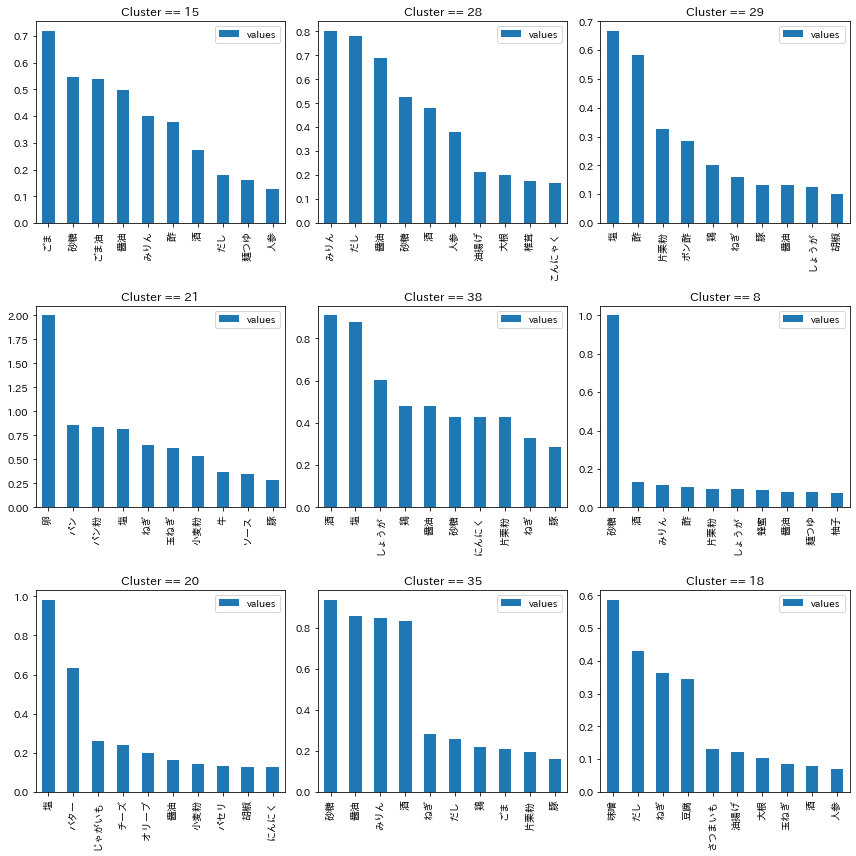

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
ax = axes.ravel()

for i, cluster in enumerate(df.cluster.unique()):
    if i > 8:
        break  

    x = df[df.cluster == cluster]
    x = x[material.columns.tolist()].sum(axis=0).to_frame() / x.shape[0]
    x.columns = ["values"]
    x.sort_values("values", ascending=False)[:10].plot(kind="bar", ax=ax[i])
    ax[i].set_title(f"Cluster == {cluster}")
    
plt.tight_layout()

# 言語処理

タイトルからベクトルを作成し、特長量とすることで分類する。

In [74]:
tf = TfidfVectorizer(analyzer="char_wb", max_df=0.5, min_df=3, ngram_range=(4, 6))

In [90]:
def clean(doc: str) -> str:
    doc = neologdn.normalize(doc)
    doc = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', doc)
    doc = "".join(["" if c in emoji.UNICODE_EMOJI else c for c in doc])
    doc = re.sub(r'(\d)([,.])(\d+)', r'\1\3', doc)
    doc = re.sub(r'\d+', '0', doc)
    doc = re.sub(r'[!-/:-@[-`{-~]', r' ', doc)
    doc = re.sub(u'[■-♯]', ' ', doc)
    return doc 
    

In [92]:
df["cln_text"] = df.recipeTitle.apply(clean)

In [101]:
documents = []
t = Tokenizer()

for doc in df.cln_text:
    tokens = []
    for token in t.tokenize(doc, wakati=True):
        tokens.append(token)

    documents.append(" ".join(tokens))

In [104]:
documents[10]

'缶詰 で 簡単   鯖 と 玉ねぎ の 味噌 煮'

In [102]:
vector = tf.fit_transform(documents).toarray()
vector.shape

(4603, 5847)

In [105]:
tsne = TSNE(n_components=3, random_state=42).fit_transform(vector)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


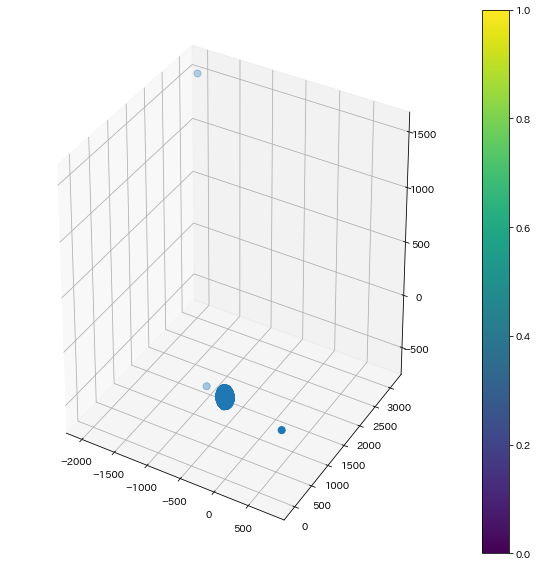

In [106]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111 , projection='3d')
sc = ax.scatter(tsne[:, 0], 
                tsne[:, 1],
                zs=tsne[:, 2],
                zdir='z',
                s=50,
                vmin=0,
                vmax=1,
                # c=[:, 3],
                cmap=plt.cm.jet) 
plt.colorbar(sc)
plt.show()

In [114]:
km = KMeans(n_clusters=35, random_state=42)
y_km = km.fit_predict(tsne)

In [115]:
pd.Series(y_km).unique()

array([14, 17, 27,  5,  0, 33, 15, 12, 11,  4, 21,  9, 18, 25, 32, 10, 22,
       31, 34,  7,  2, 19, 26, 29, 28, 16, 13, 24, 30, 20, 23,  3,  6,  8,
        1], dtype=int32)

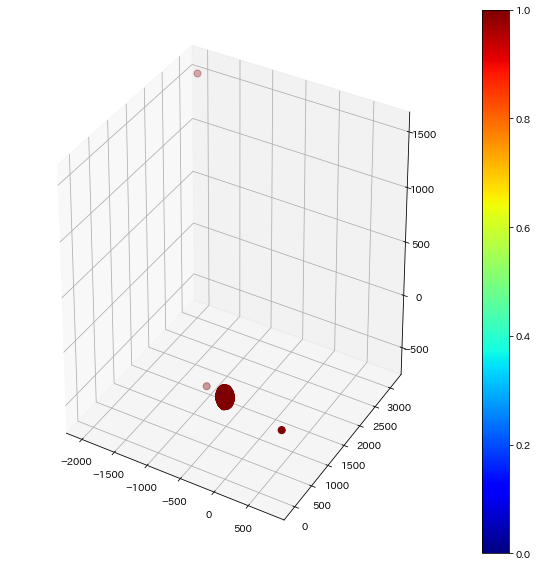

In [116]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111 , projection='3d')
sc = ax.scatter(tsne[:, 0], 
                tsne[:, 1],
                zs=tsne[:, 2],
                zdir='z',
                s=50,
                vmin=0,
                vmax=1,
                c=y_km,
                cmap=plt.cm.jet) 
plt.colorbar(sc)
plt.show()

In [117]:
df["cluster_tfidf"] = y_km 

for cluster in df.cluster.unique():
    print(f"Cluster_tfidf == {cluster}")
    display(df.loc[df.cluster_tfidf == cluster, "recipeTitle"].sample(5))
    print(f"Length {len(df[df.cluster_tfidf == cluster])}")
    print("="*20)

Cluster_tfidf == 15


2051                ゆりねのガーリックソテー
935                     スペアリブ煮込み
2303                   サイコロステーキ丼
4285             一人鍋☆手羽元のカムジャタン風
2182    簡単おつまみ！ オイルサーディンのガーリック醤油
Name: recipeTitle, dtype: object

Length 155
Cluster_tfidf == 28


1557       圧力鍋で簡単！もっちり黒豆☆甘さ控えめ
4300                 タコのマリネサラダ
1110                  かりんの砂糖漬け
4109     美味しすぎる！お店の味♥「赤かぶの漬け物」
1074    渋柿を甘柿にする方法（チンして柿の樽抜き風）
Name: recipeTitle, dtype: object

Length 143
Cluster_tfidf == 29


4275                  活力鍋で玄米酵素ご飯
1773    ＜定番＞簡単なのにコクがある！魚の煮付け（煮魚）
3762            お弁当に！ごぼうと牛肉のしぐれ煮
1846          ご飯がすすむ☆小ヤリイカと大根の煮物
691      こんなに簡単！おばあちゃんの丸ごと柚子ジャム♪
Name: recipeTitle, dtype: object

Length 137
Cluster_tfidf == 21


3059    冷やして美味しい　ふわふわ　天使のクリームパン
2487               かぼちゃと大根のお味噌汁
3665       市販のルーがなくても☆簡単ビーフシチュー
12                ヘルシー！卵オートミール粥
4213           電子レンジで超簡単！バターコーン
Name: recipeTitle, dtype: object

Length 162
Cluster_tfidf == 38


ValueError: ignored

### 結論
調味料からのクラスタリングはある程度の分離ができていそう  
文章をクレンジングしてベクトル加工することで反対に精度が下がった。


In [119]:
train = df[["cluster", "cln_text"]].rename(columns={"cluster": "target", "cln_text": "text"})
train.head()

,target,text
0,15,食べだすと、とまらない 揚げ里芋の甘辛
1,28,主人が、いくらでも食べれると絶賛のナス・ピーマン
2,29,ほっこり 里芋のひき肉あんかけ
3,21,元店長がこっそり教えるびっくり ンキーのハンバーグ
4,38,鶏胸肉で簡単 手羽風揚げない甘辛照焼チキンお弁当に


In [123]:
inputs = pd.DataFrame({"input": [v for v in vector]})
train = pd.merge(train, inputs, how="left", left_index=True, right_index=True)

del inputs 
_ = gc.collect()

In [124]:
train.head()

,target,text,input
0,15,食べだすと、とまらない 揚げ里芋の甘辛,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,28,主人が、いくらでも食べれると絶賛のナス・ピーマン,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,29,ほっこり 里芋のひき肉あんかけ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,21,元店長がこっそり教えるびっくり ンキーのハンバーグ,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,38,鶏胸肉で簡単 手羽風揚げない甘辛照焼チキンお弁当に,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 機械学習による学習


In [139]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (tr, va) in enumerate(kf.split(train, train.target)):
    print(f">>>>> fold: {fold+1}")
    x_train, x_val = vector[tr, :], vector[va, :]
    y_train, y_val = train.iloc[tr]["target"], train.iloc[va]["target"]

    model = LogisticRegression(random_state=42)
    model.fit(x_train, y_train)
    pred = model.predict(x_val).flatten()

    acc = np.sum(pred == y_val.values.ravel()) / x_val.shape[0]
    print(f"Accuracy: {acc}")


>>>>> fold: 1
Accuracy: 0.32138979370249726
>>>>> fold: 2
Accuracy: 0.2757871878393051
>>>>> fold: 3
Accuracy: 0.28664495114006516
>>>>> fold: 4
Accuracy: 0.30217391304347824
>>>>> fold: 5
Accuracy: 0.30543478260869567


In [140]:
len(train.target.unique()) / train.shape[0] # 適当に分類したときの正解する確率の理論値

0.008689984792526613

In [142]:
model = LogisticRegression(random_state=42)
model.fit(vector, train.target)
joblib.dump(model, "classification.sav")

['classification.sav']

In [144]:
model = joblib.load("classification.sav")
model.predict(vector[[12, 33], :])

array([11, 37], dtype=int32)

In [149]:
class WordPreProcessor:
    def __init__(self):
        self.tf = TfidfVectorizer(analyzer="char_wb", max_df=0.5, min_df=3, ngram_range=(4, 6))

    def wordpreprocess(self, raw_data):
        tfidf_condition = self.tf.fit(raw_data)

        vector = self.tf.transform(raw_data).toarray()
        return tfidf_condition, vector 


In [150]:
wpp = WordPreProcessor()

In [151]:
tf_c, _ = wpp.wordpreprocess(train["text"])

In [153]:
pickle.dump(tf_c, open("tfidf.pkl", "wb")) 

In [155]:
tf = pickle.load(open("tfidf.pkl", "rb"))
tf.transform(["こんにちは。"]).toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [159]:
sub = pd.read_csv("recipe.csv")
sub["cluster"] = df.cluster 

sub.drop(["mediumImageUrl", "smallImageUrl"], axis=1, inplace=True)

sub.head()

,foodImageUrl,recipeDescription,recipeTitle,recipeUrl,cluster
0,https://image.space.rakuten.co.jp/d/strg/ctrl/...,食べだすと、とまりません･:*+٩(๑❛ᴗ❛๑)۶.:+\n里芋に片栗粉をまぶして揚げたもの...,食べだすと、とまらない☆揚げ里芋の甘辛！,https://recipe.rakuten.co.jp/recipe/1950012560/,15
1,https://image.space.rakuten.co.jp/d/strg/ctrl/...,お弁当のおかずにと思って作ったら、主人が、お弁当箱の半分のスペースは、これでいいよと言うぐら...,主人が、いくらでも食べれると絶賛のナス・ピーマン,https://recipe.rakuten.co.jp/recipe/1290001623/,28
2,https://image.space.rakuten.co.jp/d/strg/ctrl/...,里芋のトロンとした食感がたまらない♪\n味をしっかり染みこませるために、ほんのひと手間をd(...,ほっこり～☆里芋のひき肉あんかけ,https://recipe.rakuten.co.jp/recipe/1370002706/,29
3,https://image.space.rakuten.co.jp/d/strg/ctrl/...,好評の為レシピを分かりやすくしました。\n分量を多少変更しました。（２０１３年３月）\n以前...,元店長がこっそり教えるびっくり◯ンキーのハンバーグ,https://recipe.rakuten.co.jp/recipe/1590002716/,21
4,https://image.space.rakuten.co.jp/d/strg/ctrl/...,鶏胸肉なのにウイング風♬骨が無いので食べ易くお弁当にもピッタリ♡油で揚げないのでヘルシーです♪,鶏胸肉で簡単♪手羽風揚げない甘辛照焼チキンお弁当に,https://recipe.rakuten.co.jp/recipe/1400014946/,38


In [160]:
sub.to_csv("recipe_processd1205.csv")